In [21]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error



In [22]:

# Load the data
data = pd.read_csv('100k_a.csv', header=None)
data.columns = ['User ID', 'Stream ID', 'Streamer Username', 'Time Start', 'Time Stop']
data.head()


,User ID,Stream ID,Streamer Username,Time Start,Time Stop
0,1,33842865744,mithrain,154,156
1,1,33846768288,alptv,166,169
2,1,33886469056,mithrain,587,588
3,1,33887624992,wtcn,589,591
4,1,33890145056,jrokezftw,591,594


In [23]:

# Calculate Watch Duration
data['Watch Duration'] = (data['Time Stop'] - data['Time Start']) * 10
grouped_data = data.groupby(['User ID', 'Streamer Username'])['Watch Duration'].sum().reset_index()


In [24]:

# Split data into training and test sets
train_data, test_data = train_test_split(grouped_data, test_size=0.2, random_state=42)


In [25]:

# Convert 'User ID' and 'Streamer Username' to categorical types
train_data['User ID'] = train_data['User ID'].astype('category')
train_data['Streamer Username'] = train_data['Streamer Username'].astype('category')
test_data['User ID'] = pd.Categorical(test_data['User ID'], categories=train_data['User ID'].cat.categories)


In [26]:

# Create sparse matrix for training data
sparse_matrix_train = csr_matrix((train_data['Watch Duration'], 
                                  (train_data['User ID'].cat.codes, 
                                   train_data['Streamer Username'].cat.codes)))


In [27]:

normalized_sparse_matrix_train = normalize(sparse_matrix_train, norm='l2', axis=1)


In [28]:

# Compute similarity matrix for content-based filtering
similarity_matrix_train = cosine_similarity(normalized_sparse_matrix_train, dense_output=False)


In [29]:

# Decompose the sparse matrix using SVD
U, sigma, Vt = svds(normalized_sparse_matrix_train, k=70)  # Adjust k as needed
sigma = np.diag(sigma)


In [30]:

def collaborative_filtering(user_id, U, sigma, Vt, user_id_categories):
    if user_id not in user_id_categories:
        return "User ID not found."
    
    user_idx = user_id_categories.get_loc(user_id)
    user_ratings = np.dot(np.dot(U[user_idx, :], sigma), Vt)
    sorted_ratings_idx = np.argsort(-user_ratings)
    sorted_ratings = user_ratings[sorted_ratings_idx]

    streamer_usernames = train_data['Streamer Username'].cat.categories[sorted_ratings_idx]

    recommendations = list(zip(streamer_usernames, sorted_ratings))
    return recommendations[:5]


In [31]:

def content_based_filtering(user_id, similarity_matrix, user_id_categories, top_n=5):
    if user_id not in user_id_categories:
        return "User ID not found."
    
    user_idx = user_id_categories.get_loc(user_id)
    user_similarity_scores = similarity_matrix[user_idx].toarray().flatten()
    sorted_indices = user_similarity_scores.argsort()[::-1]
    
    top_similar_users_indices = sorted_indices[:top_n]
    top_similar_users = user_id_categories[top_similar_users_indices]
    top_similarity_scores = user_similarity_scores[top_similar_users_indices]
    streamer_usernames = train_data['Streamer Username'].cat.categories[top_similar_users_indices]
    
    recommendations_with_scores = list(zip(streamer_usernames, top_similarity_scores))
    return recommendations_with_scores


In [32]:

def hybrid_recommendation(user_id, U, sigma, Vt, similarity_matrix, user_id_categories, alpha=0.5):
    content_based_recs = content_based_filtering(user_id, similarity_matrix, user_id_categories)
    collaborative_recs = collaborative_filtering(user_id, U, sigma, Vt, user_id_categories)

    if isinstance(content_based_recs, str):
        content_based_recs = []
    if isinstance(collaborative_recs, str):
        collaborative_recs = []

    hybrid_scores = {}
    for streamer, score in content_based_recs:
        hybrid_scores[streamer] = score * alpha

    for streamer, score in collaborative_recs:
        hybrid_scores[streamer] = hybrid_scores.get(streamer, 0) + score * (1 - alpha)

    sorted_hybrid_recs = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_hybrid_recs[:5]


In [33]:

# Function to predict watch duration
def predict_watch_duration(user_id, streamer_username, U, sigma, Vt, user_id_categories, streamer_username_categories):
    try:
        user_idx = user_id_categories.get_loc(user_id)
        streamer_idx = streamer_username_categories.get_loc(streamer_username)

        user_features = U[user_idx, :]
        streamer_features = Vt[:, streamer_idx]

        predicted_watch_duration = np.dot(np.dot(user_features, sigma), streamer_features)
        return predicted_watch_duration
    except KeyError:
        return 0 


In [34]:
def calculate_rmse_mae(test_data, U, sigma, Vt, user_id_categories, streamer_username_categories):
    y_true = []
    y_pred = []

    for _, row in test_data.iterrows():
        user_id = row['User ID']
        streamer_username = row['Streamer Username']
        actual_watch_duration = row['Watch Duration']
        predicted_watch_duration = predict_watch_duration(user_id, streamer_username, U, sigma, Vt, user_id_categories, streamer_username_categories)

        y_true.append(actual_watch_duration)
        y_pred.append(predicted_watch_duration)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    return rmse, mae


In [35]:
# Calculate RMSE and MAE for the test data
rmse, mae = calculate_rmse_mae(test_data, U, sigma, Vt, train_data['User ID'].cat.categories, train_data['Streamer Username'].cat.categories)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 147.46041051278036
MAE: 64.00306111207044


In [36]:
# Testing the model with a subset of user IDs
first_ten_user_ids = test_data['User ID'].unique()[:10]

Hybrid_total_score = 0
Collab_total_score = 0
content_total_score = 0

for user_id in first_ten_user_ids:
    # Hybrid Recommendations
    recommendations = hybrid_recommendation(user_id, U, sigma, Vt, similarity_matrix_train, train_data['User ID'].cat.categories)
    print(f"Hybrid Recommendations for User ID {user_id}:")
    for streamer, score in recommendations:
        print(f"{streamer}: {score:.2f}")
        Hybrid_total_score += score
    print("\n")

    # Collaborative Filtering Recommendations
    recommendations = collaborative_filtering(user_id, U, sigma, Vt, train_data['User ID'].cat.categories)
    print(f"Collaborative Filtering Recommendations for User ID {user_id}:")
    for streamer, score in recommendations:
        print(f"{streamer}: {score:.2f}")
        Collab_total_score += score
    print("\n")

    # Content-Based Filtering Recommendations
    recommendations = content_based_filtering(user_id, similarity_matrix_train, train_data['User ID'].cat.categories)
    print(f"Content-Based Filtering Recommendations for User ID {user_id}:")
    for streamer, score in recommendations:
        print(f"{streamer}: {score:.2f}")
        content_total_score += score
    print("\n")

print(f"Total Hybrid Similarity Distance Score: {Hybrid_total_score:.2f}")
print(f"Total Collaborative Filtering Similarity Distance Score: {Collab_total_score:.2f}")
print(f"Total Content-Based Filtering Similarity Distance Score: {content_total_score:.2f}")


Hybrid Recommendations for User ID 45683:
goingoutgunning: 0.50
boys4jesusalfa: 0.45
martial_fitness: 0.43
g0attrs: 0.42
fusionstarforce: 0.42


Collaborative Filtering Recommendations for User ID 45683:
nl_kripp: 0.17
thijs: 0.16
playhearthstone: 0.12
dogdog: 0.06
asmodaitv: 0.05


Content-Based Filtering Recommendations for User ID 45683:
goingoutgunning: 1.00
boys4jesusalfa: 0.90
martial_fitness: 0.86
g0attrs: 0.84
fusionstarforce: 0.84


Hybrid Recommendations for User ID 91831:
ohirun: 0.50
littlepixelsyt: 0.45
alice_de_dark: 0.45
archonthewizard: 0.44
crusherfp: 0.44


Collaborative Filtering Recommendations for User ID 91831:
faker: 0.23
toyzttv: 0.21
garenatw: 0.21
godjj: 0.15
asiagodtonegg3be0: 0.14


Content-Based Filtering Recommendations for User ID 91831:
ohirun: 1.00
littlepixelsyt: 0.89
alice_de_dark: 0.89
archonthewizard: 0.89
crusherfp: 0.88


Hybrid Recommendations for User ID 48942:
haywyre: 0.50
nohandde: 0.31
allakazzaror: 0.29
ilprincipeciro: 0.29
cmpuls3: 0.28




In [37]:
def calculate_precision_recall(test_set, recommendations, k):
    precisions = []
    recalls = []

    for user_id, true_items in test_set.items():
        if user_id in recommendations:
            rec_items = recommendations[user_id][:k]
            true_positives = len(set(rec_items) & set(true_items))
            precision = true_positives / len(rec_items) if rec_items else 0
            recall = true_positives / len(true_items) if true_items else 0
            
            precisions.append(precision)
            recalls.append(recall)

    average_precision = sum(precisions) / len(precisions) if precisions else 0
    average_recall = sum(recalls) / len(recalls) if recalls else 0

    return average_precision, average_recall


In [38]:
precision, recall = calculate_precision_recall(test_data, recommendations, k=5)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

Precision: 0.0000, Recall: 0.0000


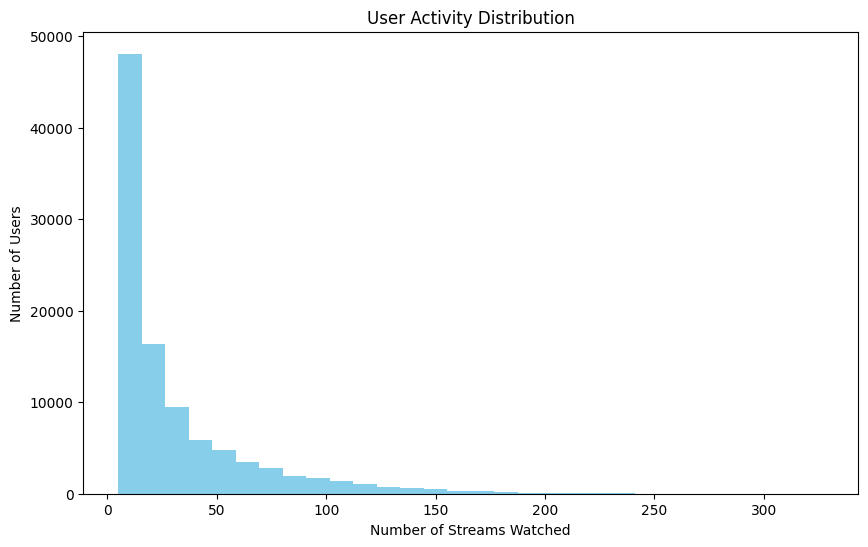

In [39]:

user_activity = data.groupby('User ID')['Stream ID'].count()

plt.figure(figsize=(10, 6))
user_activity.plot(kind='hist', bins=30, color='skyblue')
plt.title('User Activity Distribution')
plt.xlabel('Number of Streams Watched')
plt.ylabel('Number of Users')
plt.show()


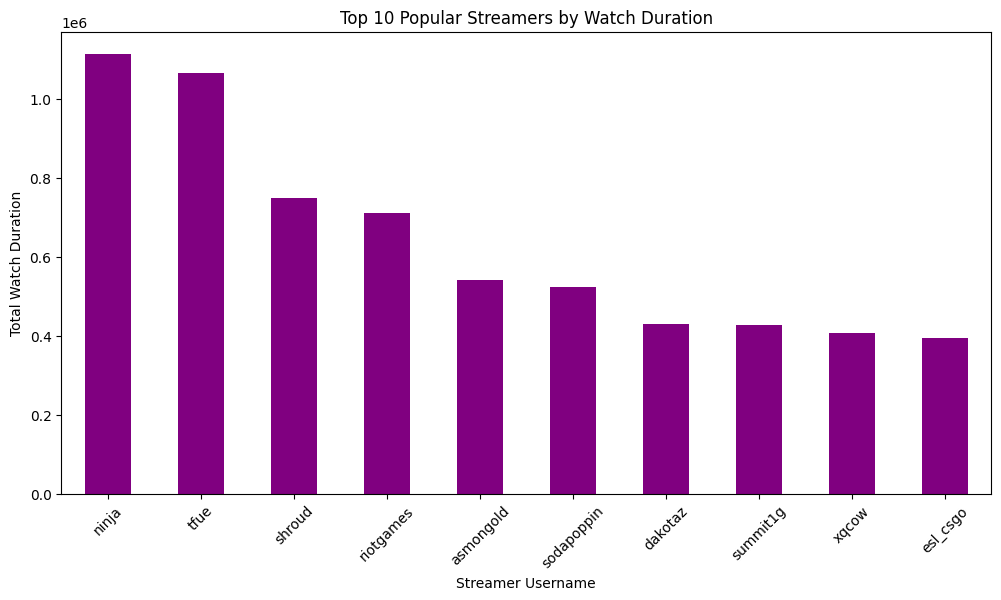

In [40]:
streamer_popularity = data.groupby('Streamer Username')['Watch Duration'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
streamer_popularity.plot(kind='bar', color='purple')
plt.title('Top 10 Popular Streamers by Watch Duration')
plt.xlabel('Streamer Username')
plt.ylabel('Total Watch Duration')
plt.xticks(rotation=45)
plt.show()


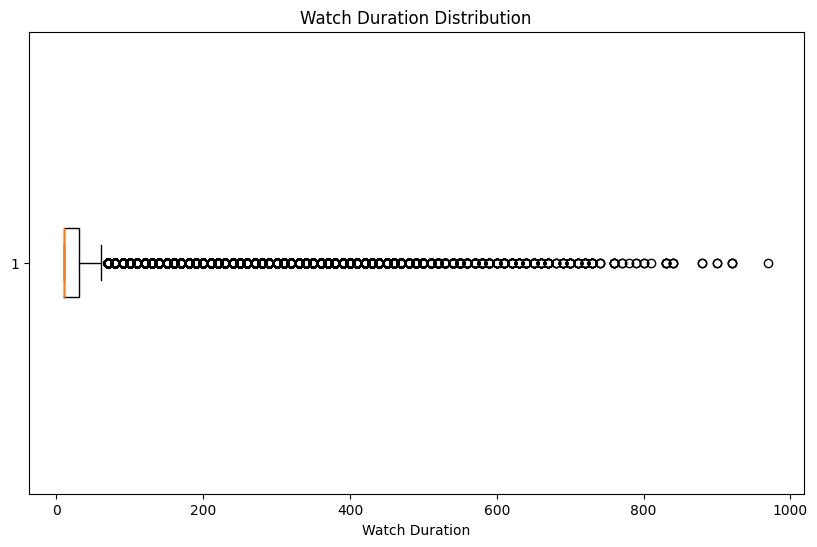

In [41]:
plt.figure(figsize=(10, 6))
plt.boxplot(data['Watch Duration'], vert=False)
plt.title('Watch Duration Distribution')
plt.xlabel('Watch Duration')
plt.show()
